In [ ]:
!gdown 1gSoSq0G_MJE6QSR-wkBOpTwYfqrCH8e7
!pip install torchmetrics
!rm -rf sample_data
!unzip samples.zip
!rm samples.zip
!rm -rf __MACOSX

In [2]:
DATA_PATH = 'samples'

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchmetrics
import os
from PIL import Image
import shutil
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Small EDA

In [7]:
images_names = os.listdir('samples')
images_datatypes = set([el.split('.')[1] for el in images_names])
print(f'Number of images in dataset: {len(images_names)}')
print(f'Images types in dataset: {images_datatypes}')

captcha_letters = set([item for sublist in [list(el.split('.')[0]) for el in images_names] for item in sublist])
print(f'Numbers of target letters: {len(captcha_letters)}')
print(f'Target letters: {list(captcha_letters)}')

images_sizes = set([Image.open(os.path.join('samples', image_name)).size for image_name in images_names])
print(f'Images sizes: {list(images_sizes)}')

captcha_lengths = set([len(el.split('.')[0]) for el in images_names])
print(f'Possible captcha length: {list(captcha_lengths)}')

Number of images in dataset: 1070
Images types in dataset: {'png', 'jpg'}
Numbers of target letters: 19
Target letters: ['5', '7', 'x', 'g', 'm', '6', 'f', 'd', '2', 'n', 'e', 'p', '4', 'w', '3', 'b', 'c', 'y', '8']
Images sizes: [(200, 50)]
Possible captcha length: [5]


### Data Preparing

In [8]:
def split_train_test_dataset(dataset_path: str,
                             test_size_ratio: float = 0.2,
                             val_size_ratio: float = 0.2,
                             train_dir: str = 'train_images',
                             val_dir: str = 'validation_images',
                             test_dir: str = 'test_images',
                             random_state: int = 0) -> None:

    images = os.listdir(dataset_path)
    n_images = len(images)
    test_size = int(n_images * test_size_ratio)
    validation_size = int((n_images - test_size) * val_size_ratio)

    random.Random(random_state).shuffle(images)

    os.makedirs(train_dir, exist_ok = True)
    os.makedirs(test_dir, exist_ok = True)
    os.makedirs(val_dir, exist_ok = True)

    for i in range(test_size):
        image_from_path = os.path.join(dataset_path, images[i])
        image_to_path = os.path.join(test_dir, images[i])
        shutil.copyfile(image_from_path, image_to_path)

    for i in range(test_size, test_size + validation_size):
        image_from_path = os.path.join(dataset_path, images[i])
        image_to_path = os.path.join(val_dir, images[i])
        shutil.copyfile(image_from_path, image_to_path)

    for i in range(test_size + validation_size, len(images)):
        image_from_path = os.path.join(dataset_path, images[i])
        image_to_path = os.path.join(train_dir, images[i])
        shutil.copyfile(image_from_path, image_to_path)

In [9]:
split_train_test_dataset('samples', 0.2, 0.2, 'train_images', 'val_images', 'test_images', 0)

In [11]:
print(f'Num train images: {len(os.listdir("train_images"))}')
print(f'Num val images: {len(os.listdir("val_images"))}')
print(f'Num test images: {len(os.listdir("test_images"))}')

Num train images: 685
Num val images: 171
Num test images: 214


In [12]:
target_symbols = ['-'] + list(captcha_letters)
char2idx = dict(zip(target_symbols, np.arange(len(target_symbols))))
idx2char = dict(zip(np.arange(len(target_symbols)), target_symbols))

In [13]:
def encode_target_batch(targets_batch, max_target_length: int = 5):
    batch_size = len(targets_batch)

    targets_lengths = torch.IntTensor([len(target) for target in targets_batch])

    encoded_targets = torch.zeros(batch_size, max_target_length, dtype=torch.int32)
    for i in range(batch_size):
        target = targets_batch[i]
        encoded_target = torch.IntTensor([char2idx[ch] for ch in target])
        encoded_targets[i, :encoded_target.shape[0]] = encoded_target
    
    return encoded_targets, targets_lengths

### Dataset & DataLoaders

In [14]:
class CaptchaDataset(torch.utils.data.Dataset):
    def __init__(self, data_folder_path: str, transform: transforms.Compose = None):
        self.dataset_path = data_folder_path
        self.images_names = os.listdir(data_folder_path)
        self.dataset_size = len(self.images_names)
        self.transform = transform

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        image_name = self.images_names[idx]
        image_path = os.path.join(self.dataset_path, image_name)
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)

        label = image_name[:image_name.rfind('.')]

        return image, label

In [15]:
image_transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Resize((50, 200)),
        transforms.Normalize((0.5, ), (0.5, ))
    ]
)

In [16]:
train_dataset = CaptchaDataset('train_images', image_transform)
test_dataset = CaptchaDataset('test_images', image_transform)
val_dataset = CaptchaDataset('val_images', image_transform)

In [17]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### Model Architecture

In [18]:
class ConvolutionalBlock(torch.nn.Module):
    def __init__(self):
        super(ConvolutionalBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=(2, 2))
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(2, 2))
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(2, 2))
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(num_features=128)
        self.act4 = nn.ReLU()

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act4(x)

        num_slices = 11

        x = x.transpose(2, 3).view(x.shape[0], x.shape[1], num_slices, x.shape[3] // num_slices, x.shape[2]).permute(0, 2, 1, 4, 3)
        x = x.reshape(x.shape[0], x.shape[1], -1)
        
        # x \in [bs x n_slice x ([H*W*channels]_flattened)]
        return x

class CRNN(nn.Module):
    def __init__(self, lstm_input_size, out_features=20, hidden_size=50, num_lstm_layers=3):
        super(CRNN, self).__init__()

        self.conv_block = ConvolutionalBlock()
        self.lstm_bidir = nn.LSTM(input_size=lstm_input_size, hidden_size=hidden_size, num_layers=num_lstm_layers, bidirectional=True)
        self.lin_layer = nn.Linear(in_features=2 * hidden_size, out_features=out_features)

    def forward(self, x):

        x = self.conv_block(x)
        lstm_out, _ = self.lstm_bidir(x)
        logits = self.lin_layer(lstm_out)

        log_sm_logits = nn.functional.log_softmax(logits, dim=2)
        log_sm_logits = log_sm_logits.permute(1, 0, 2)

        return log_sm_logits

# ConvolutionalBlock()(next(iter(train_dataloader))[0]).shape

In [19]:
def decode_predictions(log_sm_logits_batch):
    def decode_digits_to_symbols(digits_prediction):
        digits_cleaned = torch.unique_consecutive(digits_prediction)
        digits_cleaned = digits_cleaned[digits_cleaned != 0]
        digits_pred_str = ''.join([idx2char[idx.item()] for idx in digits_cleaned])
        return digits_pred_str

    softmax_values = nn.functional.softmax(log_sm_logits_batch, dim=2)
    labels_pred = torch.argmax(softmax_values, dim=2)
    labels_pred = labels_pred.permute(1, 0)
    predictions_str = [decode_digits_to_symbols(labels_pred[i]) for i in range(labels_pred.size(0))]
    return predictions_str

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def initialize_model(lstm_input_size, out_features, hidden_size, num_lstm_layers, device):
    net = CRNN(lstm_input_size, out_features, hidden_size, num_lstm_layers).to(device)
    net.apply(weights_init)
    return net

In [56]:
net = initialize_model(lstm_input_size=768, out_features=20, hidden_size=128, num_lstm_layers=2, device=device)
optimizer = optim.Adam(net.parameters(), lr=3e-4)

In [46]:
torch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total numbers of trainable parameters: {torch_total_params}')

Total numbers of trainable parameters: 1450132


### Model training

In [78]:
def draw_training_plot(hist):
    n_epochs = len(hist['loss'])

    fig, ax = plt.subplots(1, 2, figsize=(16, 4))

    ax[0].set_title('CTC Loss')
    ax[0].set_xlabel('#epoch')
    ax[0].plot(np.arange(1, n_epochs + 1), hist['loss'], label='Train Loss')
    ax[0].plot(np.arange(1, n_epochs + 1), hist['val_loss'], label='Val Loss', c='magenta')
    
    ax[1].set_title('Character Error Rate')
    ax[1].set_xlabel('#epoch')
    ax[1].plot(np.arange(1, n_epochs + 1), hist['val_cer'], label='Val CER', c='green')

    ax[0].grid(True)
    ax[1].grid(True)

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='upper right')

    plt.show()

def train_model(net, train_dataloader, val_dataloader, n_epochs=100, max_target_length=5, save_best=True, model_save_path='rcnn.pth', verbose=False):
    hist = defaultdict(list)
    best_val_metric = 1
    for ep in (range(n_epochs)):
        net.train()

        clear_output(wait=True)
        print(f'Epoch #{ep + 1}:')

        total_loss = 0
        for data, input_labels in tqdm(train_dataloader):
            optimizer.zero_grad()

            data = data.to(device)
            log_sm_logits = net(data)

            target_labels_encoded, target_labels_lengths = encode_target_batch(input_labels, max_target_length=max_target_length)

            target_labels_encoded = target_labels_encoded.to(device)
            target_labels_lengths = target_labels_lengths.to(device)

            input_lengths = torch.full(size=(log_sm_logits.size(1),), fill_value=log_sm_logits.size(0), dtype=torch.int32).to(device)

            ctc_loss = nn.CTCLoss(blank=0, reduction='mean')
            loss = ctc_loss(log_sm_logits, target_labels_encoded, input_lengths, target_labels_lengths)
            loss.backward()

            optimizer.step()

            total_loss += loss.item()
        
        val_info = validate_model(net, val_dataloader, max_target_length)

        hist['loss'].extend([total_loss])
        hist['val_loss'].extend([val_info['loss']])
        hist['val_cer'].extend([val_info['cer']])

        if val_info['cer'] < best_val_metric:
            best_val_metric = val_info['cer']
            torch.save(net.state_dict(), model_save_path)

        draw_training_plot(hist)

    if verbose:
        print('Model training was finished')

    return hist

def validate_model(net, val_dataloader, max_target_length=5, verbose=False):
    net.eval()
    with torch.no_grad():
        total_loss = 0
        all_targets = []
        all_predictions = []

        for data, input_labels in tqdm(val_dataloader):
            data = data.to(device)
            log_sm_logits = net(data)

            target_labels_encoded, target_labels_lengths = encode_target_batch(input_labels, max_target_length=max_target_length)

            target_labels_encoded = target_labels_encoded.to(device)
            target_labels_lengths = target_labels_lengths.to(device)

            input_lengths = torch.full(size=(log_sm_logits.size(1),), fill_value=log_sm_logits.size(0), dtype=torch.int32).to(device)

            ctc_loss = nn.CTCLoss(blank=0, reduction='mean')
            loss = ctc_loss(log_sm_logits, target_labels_encoded, input_lengths, target_labels_lengths)

            total_loss += loss.item()

            predictions_str = decode_predictions(log_sm_logits)
            targets = list(input_labels)
            all_targets.extend(targets)
            all_predictions.extend(predictions_str)

        cer = torchmetrics.CharErrorRate()
        cer_value = cer(all_predictions, all_targets).item()

    
    if verbose:
        print(f'Loss val: {total_loss:.3f} / CER val: {cer_value*100:.2f}%')

    clear_output(wait=True)

    return {'loss' : total_loss, 'cer' : cer_value}

def evaluate_model(net, test_dataloader, extended_return=True):
    all_targets = []
    all_predictions = []
    datas = []
    
    net.eval()
    with torch.no_grad():
        for data, labels in test_dataloader:
            datas.extend(list(data))

            data = data.to(device)
            log_sm_logits = net(data)
            predictions_str = decode_predictions(log_sm_logits)
            labels = list(labels)
            all_targets.extend(labels)
            all_predictions.extend(predictions_str)

    cer = torchmetrics.CharErrorRate()
    cer_value = cer(all_predictions, all_targets).item()

    if extended_return:
        return cer_value, datas, all_predictions, all_targets
    else:
      return cer_value

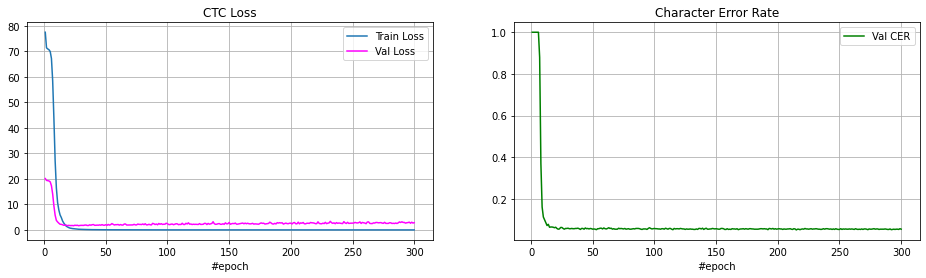

CPU times: user 7min 32s, sys: 11.9 s, total: 7min 44s
Wall time: 8min 11s


In [58]:
%%time
hist = train_model(net, train_dataloader, val_dataloader, n_epochs=300, max_target_length=5, save_best=True, model_save_path='rcnn.pth', verbose=False)

In [59]:
def load_model(model_path: str, model_params: dict):
    net = initialize_model(**model_params)
    net.load_state_dict(torch.load(model_path))
    return net

In [60]:
net_params = {'lstm_input_size' : 768, 'out_features' : 20, 'hidden_size' : 128, 'num_lstm_layers' : 2, 'device' : device}
net = load_model('rcnn.pth', net_params)

In [93]:
cer_value, images, preds, targets = evaluate_model(net, test_dataloader)
print(f'Total test CER value: {cer_value*100:.2f}%')

Total test CER value: 4.95%


### Wrong answer samples prediction (analysis)

In [94]:
targets = np.array(targets)
preds = np.array(preds)

mask = (targets != preds)

print(f'Number of wrong predicted samples: {mask.sum()}')

Number of wrong predicted samples: 50


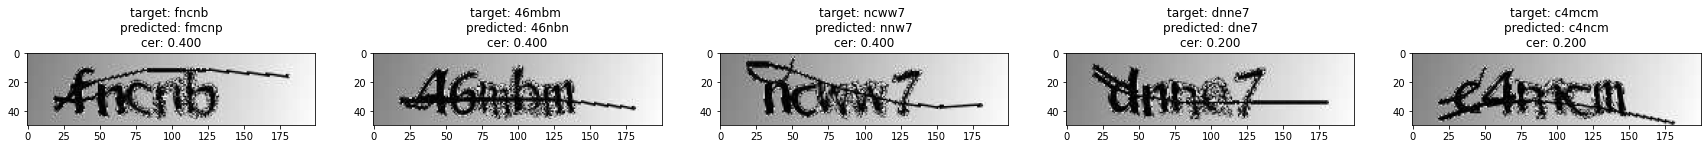

In [129]:
n_images = len(images)
cer = torchmetrics.CharErrorRate()
cer_values = [cer(preds[i], targets[i]).item() for i in range(n_images)]
cer_ids = list(zip(cer_values, np.arange(n_images)))
cer_ids = sorted(cer_ids, reverse=True)

top_n_error = 5
top_error_ids = [cer_ids[i][1] for i in range(top_n_error)]

fig, ax = plt.subplots(1, top_n_error, figsize=(30, 20))

for i in range(top_n_error):
    ind = top_error_ids[i]
    ax[i].set_title(f'target: {targets[ind]} \npredicted: {preds[ind]}\ncer: {cer_ids[i][0]:.3f}')
    ax[i].imshow(transforms.ToPILImage()(images[ind].to('cpu')), cmap='gray')

plt.show()

__Ответ:__ Как мы можем видеть, самыми сложными для модели примерами оказались те, где 1) есть похожие по написанию буквы "b"-"p", "n"-"m", а также случаи где буквы расположены слишком близко друг другу и имеют пересечения. Возможно модель не может распознать конец одной буквы и начало другой и думает, что это просто продолжение первой буквы. 
Я бы пробовал решить эти проблемы экспериментально. Первое, что я бы сделал - попробовал видоизменить архитектуру сети - добавить больше параметров, в частности конволюционных сверток, но с различными ядрами (1, 3), (3, 1), чтобы подцепить граничную информацию между буквами. И еще бы я бы попробовал поагмуентировать данные (подпортить исходные) - немножко поблюрить, размыть, накидать немного шума около темных пикселей (которые относятся к самой каптче). Еще можно увеличить количество входов у лстм-слоев. 
Но в целом, я думаю тут больший прирост даст именно изменение архитектуры и подбор параметров.